<a href="https://colab.research.google.com/github/Probingbug/24M2015_AIC./blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models, transforms
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Visualize Raw Images (28x28 Grayscale)

Custom dataset loading

In [8]:
class FashionMNIST_CSV(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform
        self.images = self.data.iloc[:, 1:].values.reshape(-1, 28, 28).astype(np.uint8)
        self.labels = self.data.iloc[:, 0].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx])
        label = int(self.labels[idx])
        if self.transform:
            img = self.transform(img)
        return img, label

**Transformation**

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert 1 → 3 channels
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

**Load Dataset**

In [10]:
train_path = "/content/fashion-mnist_train.csv"
test_path = "/content/fashion-mnist_test.csv"

train_dataset = FashionMNIST_CSV(train_path, transform=transform)
test_dataset = FashionMNIST_CSV(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

raw image dataset

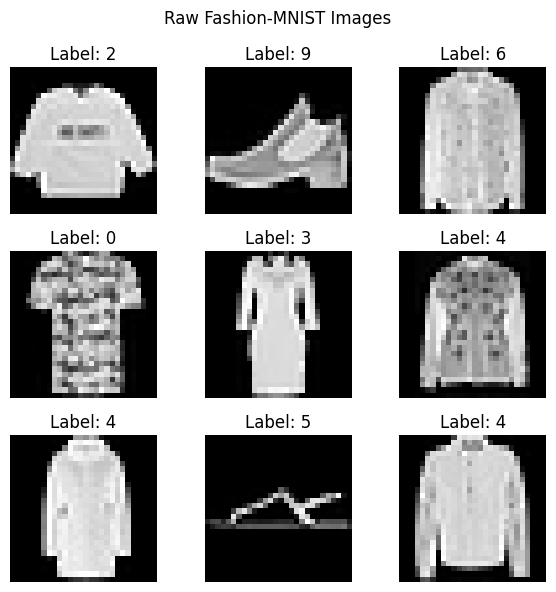

In [15]:
def visualize_raw_images(dataset, num_images=9):
    plt.figure(figsize=(6,6))
    for i in range(num_images):
        img = dataset.images[i]
        label = dataset.labels[i]
        plt.subplot(3, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.suptitle("Raw Fashion-MNIST Images")
    plt.tight_layout()
    plt.show()

visualize_raw_images(train_dataset)

transformed dataset

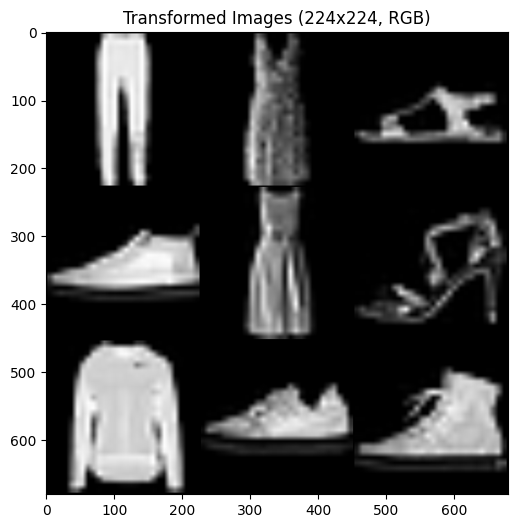

In [17]:
def show_transformed_images(dataloader):
    images, labels = next(iter(dataloader))  # Take one batch
    img_grid = torchvision.utils.make_grid(images[:9], nrow=3, normalize=True)
    npimg = img_grid.numpy().transpose((1, 2, 0))  # Convert to HWC for plt
    plt.figure(figsize=(6,6))
    plt.imshow(npimg)
    plt.title("Transformed Images (224x224, RGB)")
    plt.axis('on')
    plt.show()

show_transformed_images(train_loader)

**Load pretrained model**

In [11]:
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 10)  # Replace classifier head

# Freeze all layers except the new FC
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


**Train Only the Head**

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

for epoch in range(5):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.6085
Epoch 2, Loss: 0.4371
Epoch 3, Loss: 0.4091
Epoch 4, Loss: 0.3951
Epoch 5, Loss: 0.3870


**Evaluate on Test Data**

In [13]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 86.45%
